In [1]:
import sys
sys.path.append("..")
import torch
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]

from engression import engression
# from engression import engression_bagged
from engression.data.simulator import preanm_simulator

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Simulate data


In [3]:
x, y = preanm_simulator("square", n=10000, x_lower=0, x_upper=2, noise_std=1, train=True, device=device)
x_eval, y_eval_med, y_eval_mean = preanm_simulator("square", n=1000, x_lower=0, x_upper=4, noise_std=1, train=False, device=device)

## Engression

In [4]:
# Fit an engression model
engressor = engression(x, y, lr=0.01, num_epoches=500, batch_size=1000, device=device)

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 10]: energy-loss: 0.4707,  E(|Y-Yhat|): 1.0504,  E(|Yhat-Yhat'|): 1.1595
[Epoch 100 (20%), batch 10]: energy-loss: 0.3819,  E(|Y-Yhat|): 0.7823,  E(|Yhat-Yhat'|): 0.8009
[Epoch 200 (40%), batch 10]: energy-loss: 0.3863,  E(|Y-Yhat|): 0.7955,  E(|Yhat-Yhat'|): 0.8184
[Epoch 300 (60%), batch 10]: energy-loss: 0.4100,  E(|Y-Yhat|): 0.8340,  E(|Yhat-Yhat'|): 0.8480
[Epoch 400 (80%), batch 10]: energy-loss: 0.4690,  E(|Y-Yhat|): 0.8514,  E(|Yhat-Yhat'|): 0.7648
[Epoch 500 (100%), batch 10]: energy-loss: 0.4118,  E(|Y-Yhat|): 0.8351,  E(|Yhat-Yhat'|): 0.8465

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.6251,  E(|Y-Yhat|): 1.2511,  E(|Yhat-Yhat'|): 1.252

In [5]:
# Summarize model information
engressor.summary()

Engression model with
	 number of layers: 2
	 hidden dimensions: 100
	 noise dimensions: 100
	 number of epochs: 500
	 batch size: 1000
	 learning rate: 0.01
	 standardization: True
	 training mode: False
	 device: cpu

Training loss (original scale):
	 energy-loss: 0.63, 
	E(|Y-Yhat|): 1.25, 
	E(|Yhat-Yhat'|): 1.25


In [6]:
# Evaluation
print("L2 loss:", engressor.eval_loss(x_eval, y_eval_mean, loss_type="l2"))
print("correlation between predicted and true means:", engressor.eval_loss(x_eval, y_eval_mean, loss_type="cor"))

L2 loss: 0.05791667848825455
correlation between predicted and true means: 0.9953022003173828


In [7]:
# Predictions
y_pred = engressor.predict(x_eval, target="mean", sample_size=1000)

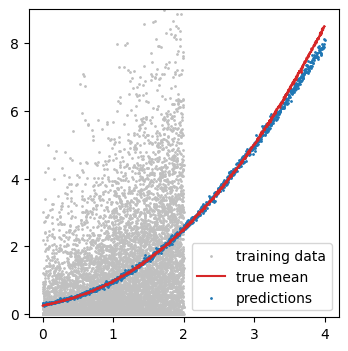

In [8]:
plt.scatter(x.cpu(), y.cpu(), label="training data", s=1, color="silver")
plt.plot(x_eval.cpu(), y_eval_mean.cpu(), label="true mean", color="C3")
plt.scatter(x_eval.cpu(), y_pred.cpu(), label="predictions", s=1)
plt.ylim(-0.1, 9)
plt.legend(); plt.show()

## Baseline: $L_2$ regression

In [9]:
from engression.models import Net

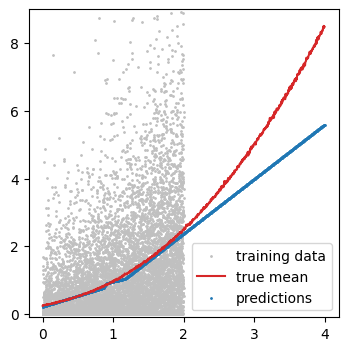

In [10]:
# Build a model with the same architecture
model = Net(num_layer=2, hidden_dim=100) # NN with the same architecture
opt = torch.optim.Adam(model.parameters(), lr=0.01) # same optimizer

# L2 regression training
model.train()
for i in range(500):
    model.zero_grad()
    y_pred = model(x)
    loss = (y_pred - y).pow(2).mean()
    loss.backward()
    opt.step()

# Evaluation
model.eval()
y_pred = model(x_eval).detach()
plt.scatter(x.cpu(), y.cpu(), label="training data", s=1, color="silver")
plt.plot(x_eval.cpu(), y_eval_mean.cpu(), label="true mean", color="C3")
plt.scatter(x_eval.cpu(), y_pred.cpu(), label="predictions", s=1)
plt.ylim(-0.1, 9)
plt.legend(); plt.show()